# Makine Öğrenmesi ile Yetenek Avcılığı Sınıflandırma
## İş problemi
Scout’lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf
(average, highlighted) oyuncu olduğunu tahminleme.
## Veri Seti Hikayesi
### scoutium_attributes.csv
#### task_response_id: Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
#### match_id: İlgili maçın id'si
#### evaluator_id: Değerlendiricinin(scout'un) id'si
#### player_id: İlgili oyuncunun id'si
#### position_id: İlgili oyuncunun o maçta oynadığı pozisyonun id’si
1: Kaleci
2: Stoper
3: Sağ bek
4: Sol bek
5: Defansif orta saha
6: Merkez orta saha
7: Sağ kanat
8: Sol kanat
9: Ofansif orta saha
10: Forvet
#### analysis_id: Bir scoutun bir maçta bir oyuncuya dair özellik değerlendirmelerini içeren küme
#### attribute_id: Oyuncuların değerlendirildiği her bir özelliğin id'si
#### attribute_value: Bir scoutun bir oyuncunun bir özelliğine verdiği değer(puan)
### scoutium_potential_labels.csv
#### task_response_id: Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
#### match_id: İlgili maçın id'si
#### evaluator_id: Değerlendiricinin(scout'un) id'si
#### player_id: İlgili oyuncunun id'si
#### potential_label: Bir scoutun bir maçta bir oyuncuyla ilgili nihai kararını belirten etiket. (hedef değişken)

In [5]:
#Gerekli kütüphanelerin importu
import pandas as pd
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,cross_validate

In [6]:
#Veri setlerini okutalım ve birleştirelim
scoutium_attributes_df=pd.read_csv("../datasets/scoutium_attributes.csv",sep=";")
scoutium_potential_labels_df=pd.read_csv("../datasets/scoutium_potential_labels.csv",sep=";")
df=pd.merge(scoutium_attributes_df,scoutium_potential_labels_df,on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])
df

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average
...,...,...,...,...,...,...,...,...,...
10725,5642,63032,151191,1909728,7,12825756,4357,67.0,highlighted
10726,5642,63032,151191,1909728,7,12825756,4407,78.0,highlighted
10727,5642,63032,151191,1909728,7,12825756,4408,67.0,highlighted
10728,5642,63032,151191,1909728,7,12825756,4423,67.0,highlighted


In [7]:
#Kaç tane oyuncu olduğuna bakalım
print("There are {} diferent players".format(df["player_id"].nunique()))

There are 277 diferent players


In [8]:
#Her mevkiden kaçar tane oyuncu olduğuna bakalım
df.groupby("position_id").agg({"player_id":"nunique"})

,player_id
position_id,
1,25
2,49
3,27
4,24
5,22
6,41
7,27
8,25
9,22


In [9]:
#Kalecileri ve potential_label'ı below_average olanları veri setinden çıkaralım
#Kalecileri çıkarma sebebimiz onlar hakkındaki verilerin yeterli olmaması, below_average olanları çıkarma sebebimiz ise
# veri setinin %1 inden azını oluşturmalarıdır
df=df[df["position_id"]!=1]
df=df[df["potential_label"]!="below_average"]
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [10]:
#Veri setimizi satırlarda sporcular, sütunlarda attribute_id'ler kesişimlerde ise attribute_value'lar olcak şekilde düzenleyelim
player_attribute_df=df.pivot_table(index=["player_id","position_id","potential_label"],
                                   columns=["attribute_id"],
                                   values="attribute_value")
player_attribute_df

attribute_id                           4322  4323  4324  4325  4326  4327  \
player_id position_id potential_label                                       
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0   
          4           average          67.0  78.0  67.0  67.0  67.0  78.0   
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0   
...                                     ...   ...   ...   ...   ...   ...   
1907347   5           average          67.0  78.0  78.0  56.0  78.0  67.0   
          6           average          67.0  67.0  67.0  67.0  67.0  67.0   
1909532   10          average          56.0  45.0  45.0  45.0  56.0  56.0   
1909724   2           highlighted      78.0  78.0  78.0  78.0  78.0  78.0   
1909728   7           highlighted      78.0  67.0  67.0  78.0  67.0  67.0   

attribute_id                           4328  4329  4330  4332  ...  4352  \
player_id position_id potential_label                          ...         
1355710   7           average          45.0  45.0  50.5  56.0  ...  56.0   
1356362   9           average          67.0  67.0  67.0  67.0  ...  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  ...  67.0   
          4           average          78.0  78.0  56.0  67.0  ...  78.0   
1356411   9           average          67.0  67.0  89.0  78.0  ...  67.0   
...                                     ...   ...   ...   ...  ...   ...   
1907347   5           average          78.0  67.0  56.0  78.0  ...  67.0   
          6           average          67.0  78.0  67.0  67.0  ...  67.0   
1909532   10          average          56.0  56.0  23.0  23.0  ...  45.0   
1909724   2           highlighted      78.0  78.0  67.0  67.0  ...  78.0   
1909728   7           highlighted      67.0  78.0  67.0  67.0  ...  67.0   

attribute_id                           4353  4354  4355  4356  4357  4407  \
player_id position_id potential_label                                       
1355710   7           average          34.0  39.5  50.5  34.0  34.0  56.0   
1356362   9           average          67.0  78.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  67.0  67.0   
          4           average          67.0  67.0  67.0  56.0  67.0  56.0   
1356411   9           average          56.0  67.0  67.0  56.0  67.0  89.0   
...                                     ...   ...   ...   ...   ...   ...   
1907347   5           average          67.0  67.0  67.0  56.0  67.0  78.0   
          6           average          67.0  78.0  67.0  67.0  67.0  67.0   
1909532   10          average          45.0  56.0  34.0  34.0  56.0  34.0   
1909724   2           highlighted      78.0  78.0  67.0  67.0  67.0  78.0   
1909728   7           highlighted      67.0  78.0  67.0  67.0  67.0  78.0   

attribute_id                           4408  4423  4426  
player_id position_id potential_label                    
1355710   7           average          34.0  34.0  56.0  
1356362   9           average          67.0  56.0  78.0  
1356375   3           average          67.0  56.0  78.0  
          4           average          67.0  45.0  56.0  
1356411   9           average          56.0  67.0  78.0  
...                                     ...   ...   ...  
1907347   5           average          78.0  78.0  56.0  
          6           average          67.0  67.0  78.0  
1909532   10          average          34.0  34.0  23.0  
1909724   2           highlighted      78.0  67.0  78.0  
1909728   7           highlighted      67.0  67.0  78.0  

[271 rows x 34 columns]

In [11]:
player_attribute_df=player_attribute_df.reset_index()
player_attribute_df.columns=[str(col) for col in player_attribute_df.columns]
player_attribute_df



,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,average,67.0,78.0,78.0,56.0,78.0,67.0,78.0,...,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
267,1907347,6,average,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
268,1909532,10,average,56.0,45.0,45.0,45.0,56.0,56.0,56.0,...,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
269,1909724,2,highlighted,78.0,78.0,78.0,78.0,78.0,78.0,78.0,...,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


In [12]:
###########################
#Modelleme
###########################

In [13]:
#Hedef değişkeni label_encoder'dan geçirelim
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe
player_attribute_df=label_encoder(player_attribute_df,"potential_label")
player_attribute_df

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,0,67.0,78.0,78.0,56.0,78.0,67.0,78.0,...,67.0,67.0,67.0,67.0,56.0,67.0,78.0,78.0,78.0,56.0
267,1907347,6,0,67.0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,67.0,78.0
268,1909532,10,0,56.0,45.0,45.0,45.0,56.0,56.0,56.0,...,45.0,45.0,56.0,34.0,34.0,56.0,34.0,34.0,34.0,23.0
269,1909724,2,1,78.0,78.0,78.0,78.0,78.0,78.0,78.0,...,78.0,78.0,78.0,67.0,67.0,67.0,78.0,78.0,67.0,78.0


In [14]:
#Numeric değişkenlere standartlaştırma uygulayalım
num_cols = [col for col in player_attribute_df.columns if player_attribute_df[col].dtypes != "O"]
num_cols=[col for col in num_cols if col not in ['player_id','position_id','potential_label']]
num_cols
scaler=StandardScaler()
for col in num_cols:
    player_attribute_df[col]=scaler.fit_transform(player_attribute_df[[col]])
player_attribute_df

,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,...,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,...,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,...,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,1907347,5,0,0.595327,1.307560,1.373158,-0.064332,1.467260,0.722929,1.355461,...,0.786581,0.813645,0.428479,0.631718,0.198319,0.768231,1.201978,1.387369,1.762816,-0.252741
267,1907347,6,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,1.083267,1.041611
268,1909532,10,0,-0.163295,-0.932790,-0.710283,-0.811501,-0.021981,-0.035936,-0.153081,...,-0.760885,-0.583384,-0.195810,-1.620856,-1.234869,0.005628,-1.487277,-1.487256,-0.955381,-2.194269
269,1909724,2,1,1.353950,1.307560,1.373158,1.430006,1.467260,1.481795,1.355461,...,1.560314,1.512160,1.052769,0.631718,0.914913,0.768231,1.201978,1.387369,1.083267,1.041611


In [15]:
#Base Models
X=player_attribute_df.drop(["player_id","position_id","potential_label"],axis=1)
y=player_attribute_df["potential_label"]
classifiers = [('XGBoost', XGBClassifier()),
               ('LightGBM', LGBMClassifier()),
               ("RandomForest",RandomForestClassifier())
               ]
for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=5,scoring=["accuracy","f1","roc_auc"])
        print("Model:{} f1 score: {}".format(name,cv_results["test_f1"].mean()))
#En iyi skoru LightGBM modeli verdi

Model:XGBoost f1 score: 0.6258721670486376
Model:LightGBM f1 score: 0.6479059829059829
Model:RandomForest f1 score: 0.6197682709447415


In [16]:
#Hiperparametre Optimizasyonu
lightgbm_model= LGBMClassifier()
lightgbm_params={"learning_rate":[0.1,0.01],
                "n_estimators":[100,300,500,100],
                "colsample_bytree":[0.5,0.7,1.0]}
lightgbm_best_params=GridSearchCV(lightgbm_model,lightgbm_params,cv=5,verbose=True).fit(X,y)
lightgbm_best_params.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'n_estimators': 300}

In [17]:
lightgbm_final=lightgbm_model.set_params(**lightgbm_best_params.best_params_).fit(X,y)
cv_results=cross_validate(lightgbm_final,X,y,cv=5,scoring=["accuracy","f1","roc_auc"])
print("Accuracy: {} F1: {} roc_auc: {}".format(cv_results["test_accuracy"].mean(),cv_results["test_f1"].mean(),cv_results["test_roc_auc"].mean()))


Accuracy: 0.8857239057239056 F1: 0.6721302691116933 roc_auc: 0.8749823819591261


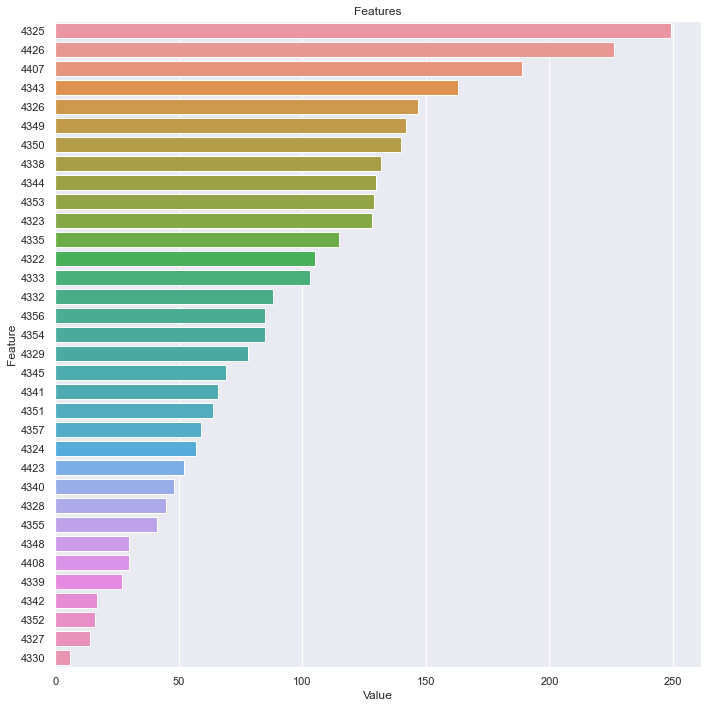

In [19]:
#Feature Importance
def plot_importance(model, features, num=len(X), save=False):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(lightgbm_final,X)